# Overwatch Hero Survey (September 2019)
Firstly, thank you to the 1200 players from [/r/cow](https://reddit.com/r/competitiveoverwatch) who took the time to fill out the survey. 

**Links**
* Responses are based on this [Google Forms survey](https://forms.gle/Rgmn2CdViBApsbP6A) 
* The raw results can be found in this [Google Sheets spreadsheet](https://docs.google.com/spreadsheets/d/1Ax1unE4I2DWW3iz2Bv4c24FTUx_qxNPwrKGZ6LGNux0) 
* Original [reddit post](https://www.reddit.com/r/Competitiveoverwatch/comments/d9cmo9/5_minute_overwatch_hero_survey_fun_vs_perception/)
* The code used to generate the results can be found on [github](https://github.com/marksimpson82/overwatch_survey).

I encourage folk to check out the [github repo](https://github.com/marksimpson82/overwatch_survey) and examine/fork & modify the code.

## Caveats
1. I'm only human; the survey and analysis may contain bias or errors. 
2. The survey might tell us _what_ people think, but it doesn't really tell us _why_. 
3. It also lacks a little context: e.g. do people find hero X unfun to play against because the hero's kit is inherently flawed, or is it because of the meta?

## Goal
I'm curious about how the community perceives hero fun (playing as and against a specific hero) vs. balance. E.g.

### Are the usual suspects _really_ that OP/un-fun? 
Rationale: We see a lot of complaint threads focusing on whoever is meta, but does the community broadly hold the same opinions or is it just a loud vocal minority? Do players tend to only dislike OP heroes, or are certain heroes unpopular regardless of their power level?

### For a player maining hero X, does hero Y grind their gears?
I'm also interested in who likes/dislikes certain heroes. E.g. my hunch is `Zen` mains hate `Doomfist` the most, while `Wrecking Ball` mains hate `Sombra` or possibly `Mei`.

## Future survey improvements (TODO):
* Collect platform (PC, PC, Xbox).
* Collect whether people enjoy playing _with_ a hero on their team.
* Collect general comments at the end.
* Re-word a few questions, specifically: 
 * Make main/most-played questions more explicit (it makes more sense to ask about the last season or two rather than historical data collected over 3+ years -- Rein today is not Rein of 2016!)

In [2]:
import pandas as pd
import seaborn as sb
import ipywidgets as widgets
import numpy as np
from ipywidgets import interact, interactive, fixed, interact_manual
from matplotlib import pyplot as plt
from matplotlib.ticker import PercentFormatter

# load flat csv files -- the survey results are a little clunky
hero_names_df = pd.read_csv("../data/overwatch_heroes.csv").loc[:,["Hero_name"]]
basic_info_df = pd.read_csv("../data/table_basic_info.csv")
hero_ratings_df = pd.read_csv("../data/table_hero_ratings.csv")

# join on Response_id such that we can more easily query the result set
joined_df = basic_info_df.set_index('Response_id').join(
    hero_ratings_df.set_index('Response_id'), 
    lsuffix='caller', 
    rsuffix='_other')

In [3]:
# handy constants
HERO_COUNT=len(hero_names_df)
COLUMN_PLAYING_AS="Playing_as"
COLUMN_PLAYING_VS="Playing_vs"

RATING_MIN=1
RATING_MAX=5

CHART_BAR_FIGSIZE = (6, 12)
CHART_HIST_FIGSIZE = (6, 6)

In [4]:
# helper functions for graphs
def set_graph_format_x_axis(ax):
    ax.set(xlim=(RATING_MIN, RATING_MAX))
    plt.xticks(np.arange(RATING_MIN, RATING_MAX + 1, 1))

In [5]:
def draw_fun_factor_graph(df, title):
    f, ax = plt.subplots(figsize=CHART_BAR_FIGSIZE)                
    ax = sb.barplot(x="Value", y="Hero", data=df)
    set_graph_format_x_axis(ax)
    ax.set_title(title)
    ax.set(xlabel="Fun factor (higher is more enjoyable)", ylabel="")

## General responses

### Q: Which game modes do people play the most?

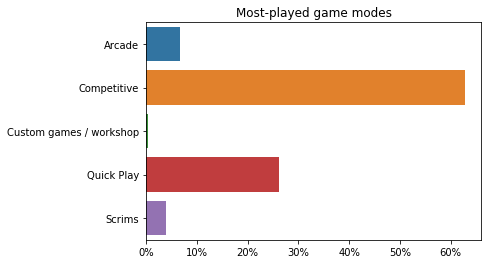

In [6]:
def draw_game_mode_chart(df):
    game_modes = (df['Game_mode']
                  .value_counts(normalize=True, sort=False)
                  .sort_index())
    
    figsize=(CHART_BAR_FIGSIZE[0], 4)
    f, ax = plt.subplots(figsize=figsize)
    ax = sb.barplot(x=game_modes.values, y=game_modes.index)    
    plt.gca().xaxis.set_major_formatter(PercentFormatter(1))
    ax.set_title("Most-played game modes")    
    
draw_game_mode_chart(basic_info_df)

#### Notes
Pretty self-explanatory. Roughly 40% of respondents play non-competitive game modes.

### Q: What rank are they?

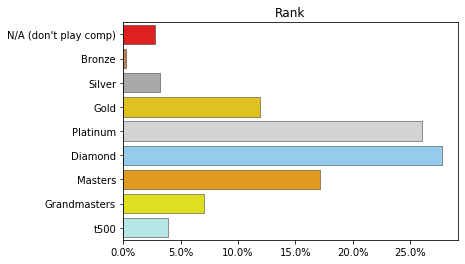

In [7]:
def draw_rank_graph(df):
    hero_time = (df['Rank']
                 .value_counts(normalize=True, sort=False))
    
    # re-order based on ascending rank so we can see the distribution
    hero_time = hero_time[[
        "N/A (don't play comp)",
        'Bronze',
        'Silver',
        'Gold',
        'Platinum',
        'Diamond',
        'Masters',
        'Grandmasters',
        't500'
    ]]
    
    palette = sb.color_palette(
        palette=[
            "red",
            "peru",
            "darkgrey",
            "gold","lightgrey",
            "lightskyblue",
            "orange",
            "yellow",
            "paleturquoise"
        ],
        n_colors=9)
     
    f, ax = plt.subplots(figsize=(CHART_BAR_FIGSIZE[0], 4))
    ax = sb.barplot(x=hero_time.values, y=hero_time.index, palette=palette, linewidth=0.5, edgecolor=".2")
    plt.gca().xaxis.set_major_formatter(PercentFormatter(1))
    
    ax.set_title("Rank")    
    
draw_rank_graph(basic_info_df)

#### Notes
This confirms what I'd expect to see -- the members of [/r/cow](https://reddit.com/r/competitiveoverwatch) tend to be higher ranked players compared to the general population. Hero choices and win rates change as players climb the ranks, so this will have a bearing on the answers.

### Q: What roles do people play?

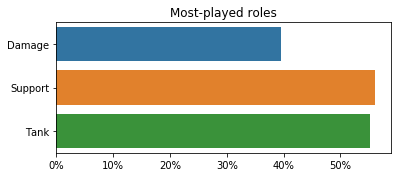

In [8]:
def draw_role_chart(df):
    roles_played_raw = (df['Most_played_roles']
                        .value_counts(normalize=True, sort=False)
                        .sort_index())
    
    TARGET_COLUMNS = ['Damage', 'Support', 'Tank']
    
    # avert your eyes -- this is messy. I'm really just looking for a simple pandas aggregation
    # method where => "if an index contains the string 'Damage', add its count to the 'Damage' sum"
    roles_played = roles_played_raw[TARGET_COLUMNS].copy()
    
    # zero these out, as we're going to re-count the originals down below
    roles_played['Damage'] = 0
    roles_played['Support'] = 0
    roles_played['Tank'] = 0    
    
    for index, value in roles_played_raw.iteritems():
        for target_col in TARGET_COLUMNS:
            if target_col in index:
                roles_played[target_col] += value    
    
    figsize=(CHART_BAR_FIGSIZE[0], 2.4)
    f, ax = plt.subplots(figsize=figsize)
    ax = sb.barplot(x=roles_played.values, y=roles_played.index)    
    plt.gca().xaxis.set_major_formatter(PercentFormatter(1))
    ax.set_title("Most-played roles")    
    
draw_role_chart(basic_info_df)

#### Notes
Respondents were able to select multiple roles. The results are weighted much more towards `Tanks` & `Supports` than `Damage` (aka `DPS`), which I wasn't expecting. This colours the survey results somewhat, so bear that in mind.

### Q: Which heroes do people main?
Rationale: Mains and favourites may well differ. While certain heroes are attractive choices due to their strength or skill curve, people may play a hero in competitive to keep the peace ("don't choose Torb or I'm staying in spawn!")

In [9]:
def draw_hero_percent_graph(df, hero_names_df, column_name, title):        
    hero_time = (df[column_name]
                 .value_counts(normalize=True))
        
    # fill in missing data where heroes got 0 votes
    hero_time = hero_time.reindex(hero_names_df["Hero_name"].values, fill_value=0.0)
    hero_time.sort_values(inplace=True, ascending=False)
    
    assert(len(hero_time) == HERO_COUNT)
        
    f, ax = plt.subplots(figsize=CHART_BAR_FIGSIZE)                
    ax = sb.barplot(x=hero_time.values, y=hero_time.index)    
    plt.gca().xaxis.set_major_formatter(PercentFormatter(1))
    ax.set_title(title)    
    plt.axvline(1.0/HERO_COUNT, 0.0, 1.0).set_linestyle('dashed')

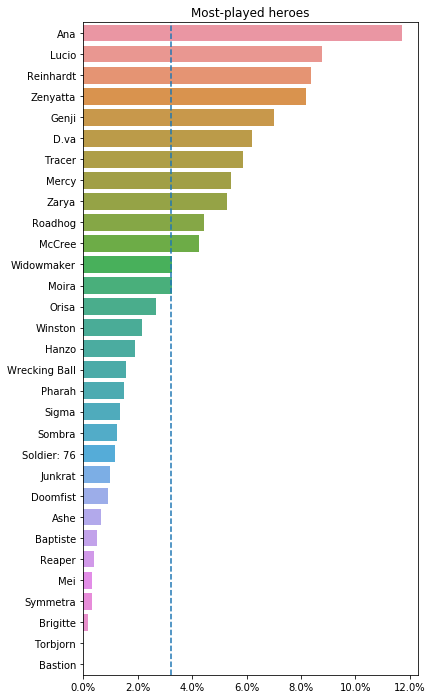

In [10]:
draw_hero_percent_graph(basic_info_df, hero_names_df, "Hero_time_1st", "Most-played heroes")

#### Notes
Caveats:

Firstly, the wording of this question was a ambiguous -- I didn't explicitly ask for the highest overall play time in their prefered game mode _or_ the most-played hero over the last season or two. I.e. respondents would've anwswered based their interpretation of the question. My hunch is that most people took the question literally and chose their most-played hero, but I can't be certain.

Secondly, `Damage` heroes (aka `DPS`) have to compete with many more heroes in their own role, so their playtime is somewhat diluted. E.g. For much of the game's life, `Ana` had to compete with `Lucio`, `Mercy` and `Zenyatta` whereas `Junkrat` had to compete with a large cast of damage dealers.

There's a number of heroes that were released at launch or shortly thereafter that sit low in the responses. That being said, heroes like `Torbjorn`, `Symmetra` and `Bastion` have always been situational.

### Q: Which heroes are our favourites?
Rationale: Again, favourites are not equivalent to main heroes. E.g. I used to main `Tracer`, but she's been weak for over a year. `Tracer` remains my favourite hero, though.

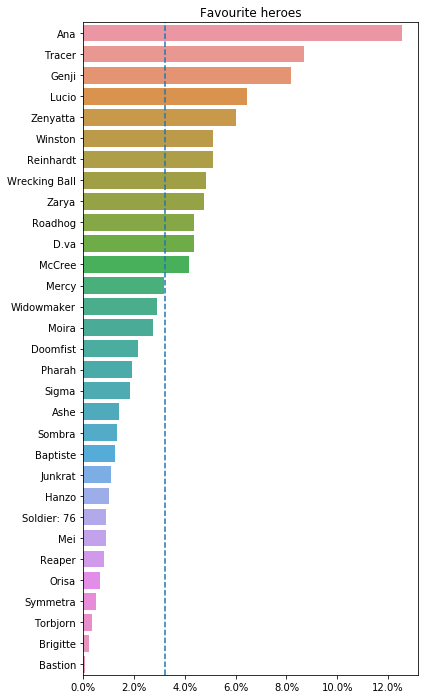

In [11]:
draw_hero_percent_graph(basic_info_df, hero_names_df, "Hero_favourite", "Favourite heroes")

#### Notes
##### We appreciate many of the older heroes
Older heroes tend to dominate in the favourite category. `Ana` is the runaway favourite; she's 50% more popular than the next challenger! 

`Wrecking Ball` is the highest placed favourite 'new' hero by quite some margin (I'm not including `Ana` as a 'new' hero as she's been around forever).

Finally, you can see certain heroes are higher in the pecking order vs. the playtime results. This is to be expected, as while we might love playing a certain hero, it's not always a viable pick.

##### Brigitte
I can't really avoid mentioning `Brigitte`. I'm not sure we can easily interpret this result; players may dislike her for any number of reasons:

* Being forced to pick `Brigitte` when she was clearly over-tuned (and this happened for *months*, even pre-GOATS)
* Residual hate; `Brigitte` destroyed beloved heroes such as `Tracer`, `Genji` and `Winston` while barely breaking a sweat
* Post-rework, players view `Brigitte` as weak
* Elitism (limited mechanical requirement)
* People just haven't warmed to `Brigitte`

I have a few friends who stomped their way up the ranks as `Brigitte` -- you'd think that'd count for *something*?

##### When choosing favourites, meta's not better
It sticks out to see just how low `Orisa`, `Reaper` & `Mei` place. All of these heroes have been viable for months and continued to gain in strength with the introduction of `Sigma`. Given that `Orisa` is currently meta but remains unpopular, perhaps the developers might consider a re-work of sorts?

Despite a number of heroes being borderline throw picks (`Tracer` ever since `Brigitte` arrived on the scene) or a form of masochism (`Ana` vs. double shield, `Reinhardt` into `Mei`/`Reaper`/`Doomfist`), the romantics among us still love these heroes.

##### The problem children
I'm a little surprised to see `Torbjorn`, `Symmetra`, `Bastion` & `Mei` so clearly at the bottom. [/r/cow](https://reddit.com/r/competitiveoverwatch) used to host endless discussions regarding one-tricks ruining the game. Either the reworks to `Torbjorn` & co largely fixed the problem, or our survey respondents are a different crowd and don't play as those heroes. 

It's also odd to see `Soldier: 76` ranking so badly, as he does much better under [Q: Which heroes are fun to play as?](#Q:-Which-heroes-are-fun-play-as?) My best guess is that he's an afterthought -- while it's fun to play the ukelele in quiet room, why even bother when there's a 130dB death metal band drowning you out?


## Q: Which heroes are fun play as?

In [12]:
def hero_fun_factor(df, response_type):
    return (df.query(f'Response_type == "{response_type}"')
            .groupby('Hero', as_index=False)
            .mean()
            .sort_values(by='Value', ascending=False))

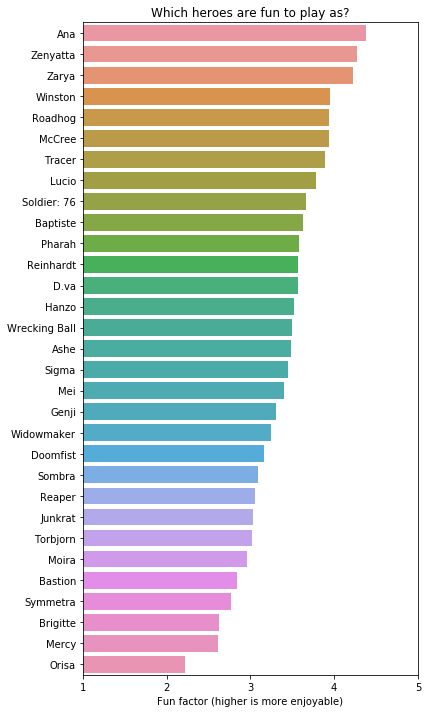

In [13]:
draw_fun_factor_graph(
    hero_fun_factor(joined_df, COLUMN_PLAYING_AS), 
    "Which heroes are fun to play as?")

#### Notes
There's a few discrepancies vs responses to the above question ([Q: Which heroes are our favourites?](#Q:-Which-heroes-are-our-favourites?)), but we can make an educated guess as to why.

##### Oh, egads! My Mercy is ruined!
While `Mercy`'s in the top half of respondents' favourites, she is considered distinctly un-fun to play as for the majority. My guess is that a subset of players *really* love playing `Mercy`, whereas other players are much less thrilled by the prospect. One person's flying angel is another's heal-bot. There's nothing wrong with that -- you don't have to please all of the people all of the time.

##### Orisa trots home in last place
Unfortunately, `Orisa` continues to skulk around the bottom. In addition to respondents stating `Orisa` is un-fun to play, `Orisa` also lacks the niche appeal of `Mercy`. I guess what I'm trying to say is that `Orisa` is neither mainstream like [Justin Beiber](https://www.youtube.com/watch?v=dQw4w9WgXcQ) nor a golden nugget like [John Prine](https://www.youtube.com/watch?v=iyRzzmjK5_Q&list=PLKl69KbB34_rPmngjlvqpXJa_Sar-aXZL). In this analogy, `Orisa` is Bunker Muzak.

##### Other interesting placings
`Baptiste` does considerably better here vs. his favourites result. This suggests `Baptiste` is fairly fun to play, but hasn't quite ousted our comfort picks just yet.

As previously mentioned, `Soldier: 76` is still hanging in there, somehow.


## Q: Which heroes are fun play against?

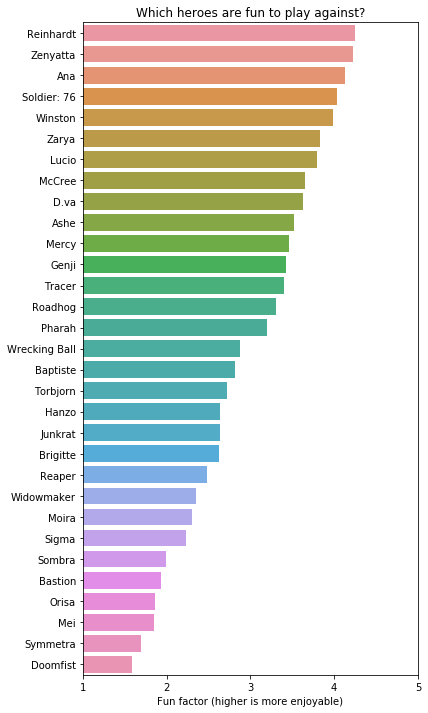

In [14]:
draw_fun_factor_graph(
    hero_fun_factor(joined_df, COLUMN_PLAYING_VS), 
    "Which heroes are fun to play against?")

#### Notes
##### Most fun to play against

To start, let's do a run-down of the Fun to Play Against Gang. They're nearly all 'old' heroes (released with the game plus `Ana`). There are a few exceptions which I'll come to, though.

* On the `Tank` front, `Reinhardt`, `Winston`, `Zarya` and `D.va` score very well. 
* For `Supports`, `Ana`, `Zenyatta`, `Lucio` and `Mercy` all feature. 
* `Soldier: 76`, `McCree`, `Genji` and `Tracer` make up the most fun to play against `DPS` crew.

For 'new' heroes, `Ashe` sneaks into the top 10, and `Wrecking Ball` sits dead-centre in the results.

##### Least fun to play against
Next, we'll consider the un-fun crowd. Much of the 'new' cast of heroes are perceived to be un-fun (with exceptions).

* `Doomfist`, `Orisa`, `Sombra` and `Brigitte` are all banished from the Kingdom of Fun. 
* As the least popular fellow by far, `Doomfist` is made to face the wall (probably in case he punches your face into it, then animation cancels your funeral).
* `Sigma` makes an appearance -- the newest hero is the 7th least fun to play against.
* `Wrecking Ball` & `Baptiste` are decently received, but can't quite crack the top half.

Overwatch's older 'problem children' remain. I fully expected to see `Symmetra`, `Mei`, `Bastion` and `Widow` lurking around the bottom. I'll come back to some of these fellows in a further question, though.

I had expected to see `Reaper` even lower on the fun chart due to his life-steal and other buffs making him an oppressive figure, but he comes in at 10th least fun to play against. 

##### A Brigitte miracle
Finally, while still placing in the bottom third, the post-rework `Brigitte` is approaching mid-table in the fun to play *against* stakes. For me, this is a borderline miraculous result. A sincere well-done to the devs is in order, as `Brigitte` is no longer the enfant terrible of Overwatch.

## Q: Which heroes are more fun to play as than to play against?
Rationale: Optimising for the fun of one player at the expense of 6 others might tell us something about why certain heroes are strongly disliked by the playerbase. 

E.g. `Doomfist` might be satisfying to play, as it's rewarding to pull off combos that have high mechanical skill requirements. However, the players on the receiving end may feel helpless and demoralised.

On the other hand, players may enjoy fragging out on `Zen`, but this is tempered by `Zen`'s sphere-like hitbox & squishy nature.

**How to interpret this chart**

For each hero, larger values on the x axis (increasing to the right) tell us a particular hero is more fun to play *as* than to play *against*. The reverse is also true; smaller values tell us the hero is more fun to play *against* than to play *as*.

In [15]:
def hero_fun_as_vs(df):
    """
    Q: For each hero, how fun are they to play _as_ instead of _against_?
    (e.g. a hero might be very fun to play as, but very un-fun to play against)
    """
    playing_as_df = (df.query('Response_type == "Playing_as"')
     .groupby('Hero')
     .mean())
    
    playing_vs_df = (df.query('Response_type == "Playing_vs"')
     .groupby('Hero')
     .mean())   
   
    fun_difference_df = (playing_as_df.join(
        playing_vs_df,    
        lsuffix='_fun_as', 
        rsuffix='_fun_vs'))      
    
    fun_difference_df["Value_fun_difference"] = (
        fun_difference_df["Value_fun_as"] - 
        fun_difference_df["Value_fun_vs"])

    fun_difference_df.sort_values(by="Value_fun_difference", inplace=True)
                
    # Initialize the matplotlib figure
    f, ax = plt.subplots(figsize=CHART_BAR_FIGSIZE)
    
    ax = sb.barplot(x="Value_fun_difference", y=fun_difference_df.index, data=fun_difference_df)    
    ax.set(xlabel="Playing as/vs fun difference", ylabel="")
        
    plt.axvline(0.0, 0.0, 1.0).set_linestyle('dashed')    

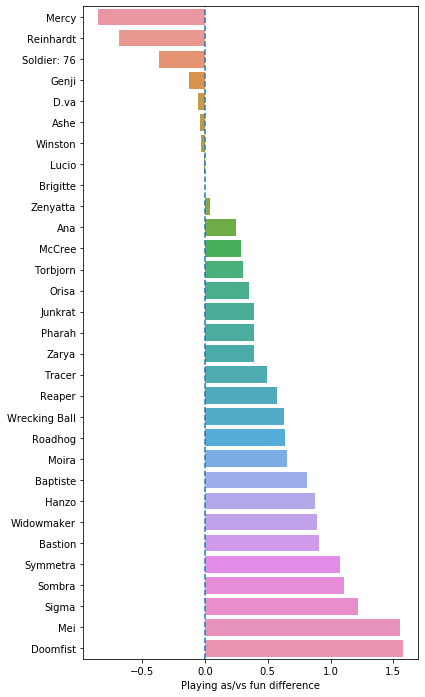

In [16]:
hero_fun_as_vs(joined_df)

#### Notes
##### Oh Mercy
`Mercy` is the hero that is considered far and away more fun to play *against* than to play *as*. This makes a lot of sense when we consider the results of a previous question (see: [Q:-Which-heroes-are-fun-play-as?](#Q:-Which-heroes-are-fun-play-as?)) -- most of the playerbase doesn't enjoy playing `Mercy`. Coupled with the fact that `Mercy` poses no real threat to most of the cast unless she's got `Valkyrie` active, this makes a lot of sense.

##### CC & one-shots
Two thirds of the cast are considered more fun to play *as* than to play *against*. It is absolutely no surprise to see many of the following heroes considered to be significantly more fun to play *as* than to play *against*:
* `Doomfist` (CC & one-shots)
* `Mei` (CC & cheerily waving)
* `Sigma` (concerning to see him here so quickly, but he has CC & few weaknesses in the double barrier meta)
* `Sombra` (CC) 
* `Widowmaker` (one-shots)
* `Hanzo` (one-shots)

... and so on. There seems to be a distinct pattern here -- CC & one-shots are fun for the person dishing them out, but less so when the roles are reversed.

## Q: Where do heroes fall on the balance scale? 
Rationale: Gives us a feel for heroes that are considered weak/balanced/over-tuned (aka OP). This allows interesting questions to be asked later, too.

In [17]:
def hero_balance(df):
    return (joined_df.query('Response_type == "Balance"')
            .groupby('Hero', as_index=False)
            .mean()
            .sort_values(by='Value', ascending=False))

In [18]:
def draw_hero_balance_graph(df):
    f, ax = plt.subplots(figsize=CHART_BAR_FIGSIZE)
    ax = sb.barplot(x="Value", y="Hero", data=df)
    set_graph_format_x_axis(ax)
    
    # plot ideal balance line
    balance_line_x = CHART_BAR_FIGSIZE[0] * 0.5
    plt.axvline(balance_line_x, 0.0, 1.0).set_linestyle('dashed')
    
    ax.set_title("Which heroes are perceived to be balanced?")
    ax.set(xlabel="1 = Weak, 3 = Balanced, 5 = Strong", ylabel="")

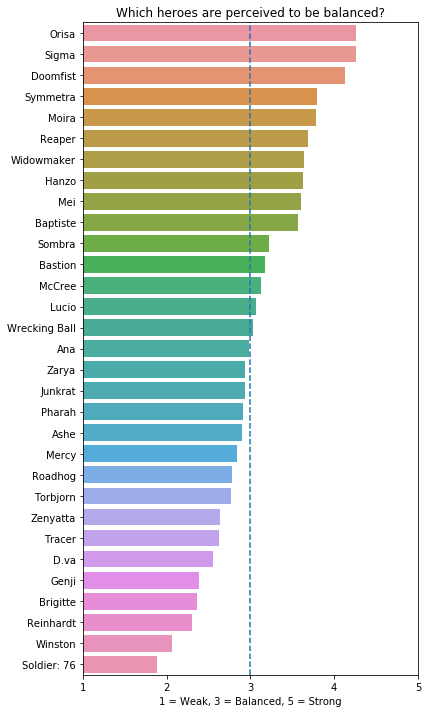

In [19]:
draw_hero_balance_graph(hero_balance(joined_df))

#### Notes
##### The over-powered
All of the meta heroes are accounted for in the OP list (`Orisa`, `Sigma`, `Doomfist` etc.)

##### The weak
Similarly, many of the underpowered choices are predictable: `Soldier: 76`, `Winston`, `D.va`, `Genji`, `Tracer`. We've seen many threads on forums about these heroes, so I shan't dwell on them.

Many of the weak heroes lack burst damage, burst heal or shields. Even the seemingly meta-proof `D.va` is finding things tough.

##### Brigitte (again)
`Brigitte` is once again having a rough time. `Brigitte` is not only considered un-fun to play *as* & somewhat un-fun to play *against*, but she's also perceived as being incredibly weak. However, the best evidence I have directly contradicts this result: her [win rate on overbuff](https://www.overbuff.com/heroes/brigitte) is currently a thumping 57 or 58% -- the highest in the game at the moment! Time to hire an image consultant and buy some instagram follows, hen.

##### Sombra: balanced, yet can't win?
`Sombra` is considered to be reasonably strong-ish, but her [winrate is in the toilet](https://www.overbuff.com/heroes/sombra) at 43% overall (the worst in the entire game, though it rises to 48% in `Grandmasters`). What's behind the disconnect? Perhaps players find `Sombra`'s mere presence oppressive, so they lose sight of the bigger picture? 

The new meta combined with global ultimate charge nerfs pushed `Sombra` out of contention due to her heavy reliance on `EMP`. Either way, it's worrying that `Sombra` can't buy a win at lower ranks and is still perceived as strong-ish. Perhaps `Sombra` is still strong in isolation and will ghost back into contention with a meta change.

##### Reinhardt mains should form a support group
`Reinhardt` is amongst the weakest, but this flies in the face of a marginally positive [win rate](https://www.overbuff.com/heroes/reinhardt). I feel this may once again play into how people *feel* while playing `Reinhardt`. He may win more than he loses, but it's a common complaint that he gets pinballed, punched, hacked, frozen, booped etc. to the point where playing him is a masochistic exercise.

## Q: Which heroes are fun to play against relative to their perceived balance?
Rationale: I'd expect to see something approaching an inversely proportional relationship between hero strength and fun playing *against* them (i.e. the more OP a hero is, the less fun it is to play *against* them).

Are there any weak heroes that significantly buck this trend? If so, it suggests the hero design may have inherent problems.

**How is the result calculated?**

I'd suggest [reading the code](https://github.com/marksimpson82/overwatch_survey/blob/35ba66e3f9ef05bcd8804bebfec0c540366c9d3d/overwatch_survey/Analysis.ipynb#L779-L802) in github, but the basic idea is this:

* Take the playing *against* un-fun/fun rating and transform it from the range `[1, 5]` => `[-1, 1]` (larger values are more fun)
* Take the balance rating and transform it from the range `[1, 5]` => `[-1, 1]` (-1 is weak, 0 is balanced, 1 is strong)
* Add these two values together. 

**Possible interpretations**

I'd say the negative values are way more interesting.

* If a hero is un-fun *and* OP, the result will be close to 0 
  * The hero is probably just un-fun due to being OP rather than any inherent design problem. Tuning will resolve it.
* If a hero is un-fun *and* weak, the result will be strongly negative 
  * Not only is the hero weak, but nobody likes them. May suggest a design flaw.
* If a hero is fun *and* balanced, the result will be positive
  * The hero design is in a great place.
* If a hero is fun *and* OP, the result will be strongly positive
  * The hero design is in a great place, to the point where they kill us and we say "yes sir, thank you sir".

In [20]:
def hero_fun_vs_balance(df):
    """
    Q: which heroes are unpopular relative to their perceived balance level? 
    (i.e. people dislike playing against them even if they're not considered OP)
    """
    playing_vs_df = (df.query('Response_type == "Playing_vs"')
     .groupby('Hero')
     .mean())
    
    balance_df = (df.query('Response_type == "Balance"')
     .groupby('Hero')
     .mean())
    
    # our fun and balance ranges go from [1, 5], so let's move them into the range
    # 0 to 4, then transform them into the range [-1, +1]. E.g. a 1 => -1, 5 => 1
    # this will make it easy to see if they 'cancel out' or not
    playing_vs_df = (playing_vs_df - 3.0) / 2.0
    balance_df = (balance_df - 3.0) / 2.0
    
    fun_balance_df = (playing_vs_df.join(
        balance_df,    
        lsuffix='_fun', 
        rsuffix='_balance')
      .query('Value_balance.notnull()')) # filter out the invalid joined data; should do this first though
    
    # this is a little arbitrary, but gives us a decent idea of 'fun/unfun' vs balance.    
    # we have a fun rating range [-1, 1] and a strength rating range [-1, 1]. 
    # 
    # we'd expect to see something of an inverse relationship between fun and balance,
    # so we're going to add them together and plot the whole lot. Adding the two values
    # should roughly cancel out, and anything that significantly departs from 0 should 
    # give us a feel for outliers in a fun/power relationship.
    # 
    # Examples:
    #
    # 1. hero that is viewed as well-balanced and also OK to play against:
    #   fun: 0.1, strength: -0.05 (i.e. these values are both close to 0)
    #   result: 0.1 + (-0.05) = 0.05
    #   interpretation: fun and balance are in check
    #
    # 2. hero that is un-fun and also also weak:
    #   fun: -0.5, strength: -0.3 (i.e. these values are both negative)
    #   result: -0.5 + (-0.3) = -0.8
    #   interpretation: the hero design has inherently un-fun elements even though weak.
    #
    # 3. hero that is fun and also slightly OP
    #   fun: 0.7, strength: 0.3
    #   result: 0.7 + 0.3 = 1.0
    #   interpretation: the hero design is inherently so much fun that we forgive the OPness
    fun_balance_df["Value_relative_balance"] = (
        fun_balance_df["Value_balance"] + 
        fun_balance_df["Value_fun"])

    fun_balance_df.sort_values(by="Value_relative_balance", inplace=True)
    return fun_balance_df    
    
def draw_hero_fun_vs_balance_graph(df):
    # Initialize the matplotlib figure
    f, ax = plt.subplots(figsize=CHART_BAR_FIGSIZE)
    
    ax = sb.barplot(x="Value_relative_balance", y=df.index, data=df)    
    ax.set(xlabel="Playing against hero: fun relative to balance", ylabel="")
    
    # plot balance vs. fun baseline. Any hero to the <--- left of this line is considered
    # un-fun relative to their balance level. 
    balance_line_x = 0.0
    plt.axvline(balance_line_x, 0.0, 1.0).set_linestyle('dashed')


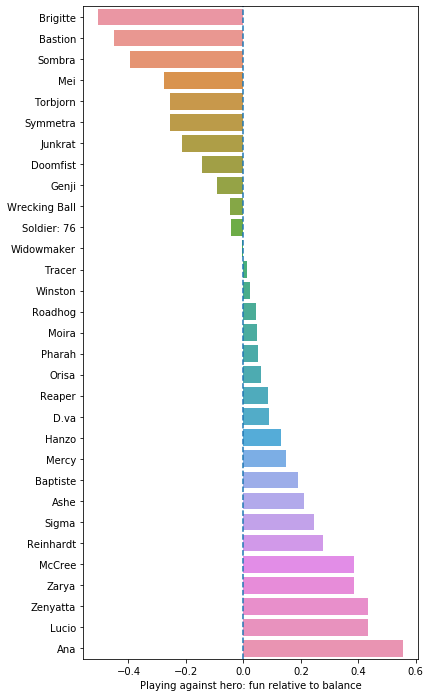

In [21]:
draw_hero_fun_vs_balance_graph(
    hero_fun_vs_balance(joined_df))

#### Notes
##### Negatives
Let's focus on the negative values. Firstly, poor `Brigitte` can't catch a break. I'm going to move on, as I've discussed her enough.

The rest of the negatives are pretty much what I expected to see -- heroes that are considered to be well-balanced yet un-fun to play against:

* `Bastion` is a niche pick, kills quickly, has a self-heal, often requires his team to build around him and takes a lot more coordination to stop than to use. I can't ever recall a teammate saying, "Yay, they're playing pirate ship!", either. Even if `Bastion` is perceived to be fairly well-balanced, respondents strongly dislike playing against him.


* `Sombra`. Despite the perception of her being well-balanced, her balance/fun ratio is out of sorts. `Sombra` appears behind her enemies and silences their abilities. This is especially the case for `Tanks` like `Reinhardt`, `D.Va` and `Wrecking Ball` who need the support of their team to survive a successful hack. I suspect the loss of agency & feeling of helplessness makes `Sombra` unpopular.


* `Mei` has the most devilish CC in the game and can also capitalise on a lack of coordination (her wall also happens to perfectly fit most choke points and is difficult to break due to its high health and multiple sections).


* `Torbjorn` has an auto-aiming turret, high burst damage and a spammy area denial ultimate. I'm somewhat surprised to see he's neck and neck with `Mei` and `Symmetra`, though. Perhaps people's dislike for `Torbjorn` one-tricks has influenced the voting, or I'm missing something. I'm looking forward to reading your comments.


* `Symmetra` has CC turrets that can surprise, slow & quickly kill squishies, a fight-winning (and visually noisy) ult that is almost indestructible *and* has received many buffs to her damage & beam. In the current double shield meta, her damage is strong. 


* `Junkrat` has a sneaky trap, long-range spam capabilities, two mines and an ult that is strong at lower levels of play.

##### The rest
`Doomfist` is so universally disliked at this point that it's hard to read much into his negative rating. Blizzard has a formidable task ahead to balance him, as he tends to be useless and niche, or infuriatingly oppressive (especially when played into heroes that rely on their teammates for peel). 

The heroes that have the largest positive ratings are our usual motley crew of old heroes: `Ana`, `Lucio`, `Zenyatta` etc. These heroes are well-balanced and score very well in the fun to play against category.

One interpretation of `Sigma`'s positive score here (despite being considered one of the most OP heroes in the game) is that his kit is not inherently un-fun to play against -- `Sigma` may just need his power pared back via small tweaks.

### Let's break down balance by hero & see the range of votes
Rationale: More of a curiosity, but are heroes viewed largely uniformly (bell curve distribution) or are some heroes more divisive, with a more equal distribution of votes for weak/balanced/OP?

In [22]:
@interact
def hero_balance_histograms(column=list(sorted(hero_names_df['Hero_name']))):
    hero_playing_vs_df = (joined_df.query('Response_type == "Playing_vs"')
                          .groupby('Hero'))['Value']

    # todo: figure out how to make the axis labels marry up with the result buckets a bit better.
    f, ax = plt.subplots(figsize=CHART_HIST_FIGSIZE)
    sb.set_style("ticks")
    dp = sb.distplot(hero_playing_vs_df.get_group(column), bins=5, kde=False)
    dp.set(xlabel=f'Playing vs {column}', ylabel='Counts')    
    plt.show()        

interactive(children=(Dropdown(description='column', options=('Ana', 'Ashe', 'Baptiste', 'Bastion', 'Brigitte'…

## Q: When maining a specific hero, which heroes are fun/un-fun to play against?
Rationale: Do the hero fun/un-fun rankings change significantly by which hero the respondents main, or are some heroes just universally unpopular to play against?

E.g. my hunch is `Zen` mains hate `Doomfist` the most, while `Wrecking Ball` mains hate `Sombra` or possibly `Mei`.

In [23]:
def hero_fun_vs_balance_by_main(df, hero_names):    
    @interact
    def hero_fun_vs_balance_by_main_interact(column=hero_names):        
        hero_name = column
        hero_playing_as_df = (df.query(
            f'Hero_favourite == "{hero_name}" & Response_type == "Playing_vs"'))
                
        response_count_for_main = int(len(hero_playing_as_df) / len(hero_names))
        
        if response_count_for_main < 1:            
            print(f"There were {response_count_for_main} responses from {hero_name} mains. Nothing to display.")
            return        

        # for hero x, we have results for playing against all heroes. 
        # spin through every result in this set and query for the top 3 most-hated
        least_fun_group = (hero_playing_as_df
                           .query(f'Response_type == "Playing_vs"')
                           .groupby("Hero", as_index=False))

        least_fun_mean = (least_fun_group.mean()
                          .sort_values(by='Value'))
        
        # Initialize the matplotlib figure
        f, ax = plt.subplots(figsize=CHART_BAR_FIGSIZE)
        ax = sb.barplot(x="Value", y="Hero", data=least_fun_mean)
        #set_graph_format_x_axis(ax)
        ax.set_title(f"Respondents' main: {hero_name}. (N: {response_count_for_main})")
        ax.set(xlabel="Fun factor (higher is more enjoyable)", ylabel="Playing against hero")
        set_graph_format_x_axis(ax)
        
hero_fun_vs_balance_by_main(joined_df, list(sorted(hero_names_df['Hero_name'])))

interactive(children=(Dropdown(description='column', options=('Ana', 'Ashe', 'Baptiste', 'Bastion', 'Brigitte'…